Default dataset name: ms1_0605-0621_40_ok_v3



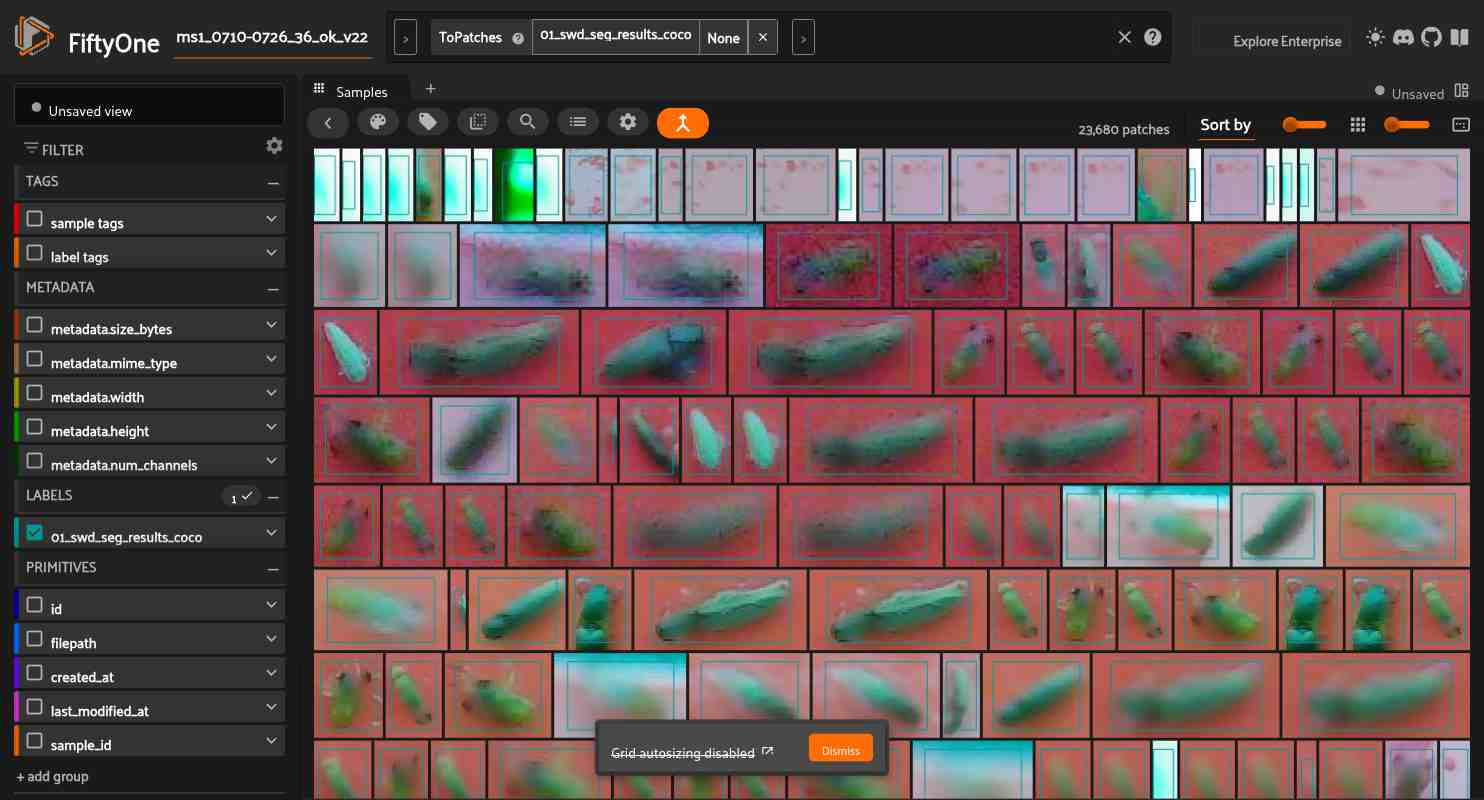

In [2]:
import fiftyone as fo

dataset_name = fo.list_datasets()[0]
if dataset_name is None:
    session = fo.launch_app(port=5151)
else:
    dataset = fo.load_dataset(dataset_name)
    print(f"Default dataset name: {dataset_name}")
    session = fo.launch_app(dataset,port=5151)

In [8]:
from fiftyone import ViewField as F
import fiftyone.types as fot

patches_view = session.view   # 💡 当前 App 的视图（包含你所有筛选）

print(patches_view)

Dataset:     ms1_0710-0726_36_ok_v22
Media type:  image
Num patches: 23680
Patch fields:
    id:                      fiftyone.core.fields.ObjectIdField
    filepath:                fiftyone.core.fields.StringField
    tags:                    fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:              fiftyone.core.fields.DateTimeField
    last_modified_at:        fiftyone.core.fields.DateTimeField
    sample_id:               fiftyone.core.fields.ObjectIdField
    01_swd_seg_results_coco: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detection)
View stages:
    1. ToPatches(field='01_swd_seg_results_coco', config=None)


In [9]:
from ultralytics import YOLO
from PIL import Image
from fiftyone.utils.patches import ImagePatchesExtractor
from tqdm import tqdm

# 1. 加载模型（只需要加载一次）
model = YOLO(
    "/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/02_models/best_models/91_swd_cls/data_split_0.6_0.4_0.0_yolo11m-cls_4.pt"
)

def classify_patches(patches_view, max_patches=10):
    """
    对 FiftyOne patches_view 里的 patch 做分类。
    返回一个 list，每个元素是：
    {
        "index": patch在本次迭代中的序号,
        "top1_label": "swd",
        "top1_score": 0.4902,
        "top5": [
            {"label": "swd", "score": 0.4902},
            {"label": "ok", "score": 0.4836},
            {"label": "others", "score": 0.0262},
            ...
        ]
    }
    """
    extractor = ImagePatchesExtractor(patches_view, force_square=True)
    total = len(patches_view) if max_patches is None else min(len(patches_view), max_patches)
    predictions = []

    for idx, patch in enumerate(tqdm(extractor, total=total, desc="Classifying patches")):
        # patch 是 numpy array (H, W, 3)，YOLO 能直接吃，也可以转成 PIL
        image = Image.fromarray(patch)  # 不一定要手动 resize，YOLO 会自己处理

        # 运行推理，取第 0 个结果即可
        result = model.predict(image, verbose=False)[0]
        probs = result.probs          # Probs 对象
        names = result.names          # {class_id: "class_name"}

        # ---- top 1 结果 ----
        top1_id = int(probs.top1)
        top1_conf = float(probs.top1conf)
        top1_label = names[top1_id]

        # ---- top 5 结果整理成 (label, score) 列表 ----
        top5_ids = probs.top5               # e.g. [2, 0, 1]
        top5_confs = probs.top5conf         # tensor([...])
        top5 = [
            {
                "label": names[int(cid)],
                "score": float(conf),
            }
            for cid, conf in zip(top5_ids, top5_confs)
        ]

        pred = {
            "index": idx,
            "top1_label": top1_label,
            "top1_score": top1_conf,
            "top5": top5,
        }
        predictions.append(pred)

        # ---- 友好打印 ----
        # print(f"[{idx}] top1: {top1_label} ({top1_conf:.4f})")
        # top5_str = ", ".join(
        #     f"{p['label']}={p['score']:.4f}" for p in top5
        # )
        # print(f"   top5: {top5_str}")

        # 只跑前 max_patches 个 patch，方便 debug
        if max_patches is not None and idx + 1 >= max_patches:
            break

    return predictions


# 2. 批量分类并标记
predictions = classify_patches(patches_view, max_patches=None)
display("Predictions:", predictions)


Classifying patches: 100%|██████████| 23680/23680 [35:40<00:00, 11.06it/s]


'Predictions:'

[{'index': 0,
  'top1_label': 'swd',
  'top1_score': 0.9997543692588806,
  'top5': [{'label': 'swd', 'score': 0.9997543692588806},
   {'label': 'others', 'score': 0.00017588670016266406},
   {'label': 'ok', 'score': 6.975197902647778e-05}]},
 {'index': 1,
  'top1_label': 'swd',
  'top1_score': 0.9992412328720093,
  'top5': [{'label': 'swd', 'score': 0.9992412328720093},
   {'label': 'others', 'score': 0.0004639983526431024},
   {'label': 'ok', 'score': 0.00029487229767255485}]},
 {'index': 2,
  'top1_label': 'swd',
  'top1_score': 0.9998176693916321,
  'top5': [{'label': 'swd', 'score': 0.9998176693916321},
   {'label': 'ok', 'score': 0.00010472243593540043},
   {'label': 'others', 'score': 7.762866880511865e-05}]},
 {'index': 3,
  'top1_label': 'swd',
  'top1_score': 0.9993054866790771,
  'top5': [{'label': 'swd', 'score': 0.9993054866790771},
   {'label': 'others', 'score': 0.0004925221437588334},
   {'label': 'ok', 'score': 0.00020205283362884074}]},
 {'index': 4,
  'top1_label': 's

In [10]:
from collections import Counter

# 取 top1 类别作为最终标签
pred_labels = [p["top1_label"] for p in predictions]

print("Total patches:", len(pred_labels))
class_counts = Counter(pred_labels)
print("Class counts:", class_counts)


Total patches: 23680
Class counts: Counter({'swd': 19843, 'ok': 2356, 'others': 1481})


In [ ]:
for sample, pred in zip(patches_view, predictions):
    tag = pred["top1_label"]
    top5_labels = [t["label"] for t in pred["top5"]]
    top5_scores = [t["score"] for t in pred["top5"]]
    obj = sample["01_swd_seg_results_coco"]
    if obj is None:
        continue
    obj["cls_top5"] = list(zip(top5_labels, top5_scores))
    obj.tags.append(tag)  
    sample.save()
